Entraîne les réseaux des neurones en les entrainant sur des parties de gnugo


In [ ]:
import tensorflow.keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, LocallyConnected2D, SeparableConv2D
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.constraints import max_norm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import activations

In [ ]:
from import_data import import_data

On prends que l'on généère en faisant jouer Gnugo

In [16]:
X, y_priors, y_values = import_data(historique=1, liberties=3)

X_train, X_test, y_prior_train, y_prior_test, y_value_train, y_value_test = train_test_split(X, y_priors, y_values, test_size=0.2)

print(X_train.shape)
print(y_prior_train.shape)
print(y_value_train.shape)

308 parties rejetées par le goban, reste 6053 parties
(38739, 9, 9, 6)
(38739, 82)
(38739,)


On crée le modèle pour les priors. Celui ci retournera les probabilités de gagner pour chaque coup jouer (d'où la sortie de taille 82) .

In [93]:
model = Sequential()
model.add(Conv2D(64, kernel_size=5, input_shape=X[0].shape, padding ="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=3, padding ="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(1024, activation='tanh', kernel_regularizer=regularizers.l1(1e-5)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l1(1e-5)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='tanh'))
model.add(Dense(82, activation='sigmoid')) 

opt = optimizers.Adam(lr=1e-3)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['mae'])
model.summary()


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 9, 9, 64)          9664      
_________________________________________________________________
batch_normalization_95 (Batc (None, 9, 9, 64)          256       
_________________________________________________________________
activation_95 (Activation)   (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 9, 9, 64)          36928     
_________________________________________________________________
batch_normalization_96 (Batc (None, 9, 9, 64)          256       
_________________________________________________________________
activation_96 (Activation)   (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 5184)            

In [94]:
class History(Callback):
    def __init__(self):
        self.history = {}
    def on_epoch_end(self, epoch, logs={}):
        for k,v in logs.items():
            if not k in self.history: self.history[k]=[]
            self.history[k].append(v)
        
history=[History()]

# hyperparamètres
epochs = 100
batch_size = 64

# training
print("Training ...")
model.fit(X_train, y_prior_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_test, y_prior_test),
          callbacks=history)

Training ...
Epoch 1/100
606/606 - 7s - loss: 0.7180 - mae: 0.2599 - val_loss: 0.6372 - val_mae: 0.2623
Epoch 2/100
606/606 - 6s - loss: 0.6166 - mae: 0.2524 - val_loss: 0.6204 - val_mae: 0.2591
Epoch 3/100
606/606 - 6s - loss: 0.6148 - mae: 0.2507 - val_loss: 0.6131 - val_mae: 0.2506
Epoch 4/100
606/606 - 6s - loss: 0.6148 - mae: 0.2498 - val_loss: 0.6176 - val_mae: 0.2579
Epoch 5/100
606/606 - 6s - loss: 0.6139 - mae: 0.2486 - val_loss: 0.6162 - val_mae: 0.2443
Epoch 6/100
606/606 - 6s - loss: 0.6138 - mae: 0.2460 - val_loss: 0.6213 - val_mae: 0.2537
Epoch 7/100
606/606 - 6s - loss: 0.6045 - mae: 0.2441 - val_loss: 0.6099 - val_mae: 0.2453
Epoch 8/100
606/606 - 6s - loss: 0.6013 - mae: 0.2431 - val_loss: 0.6163 - val_mae: 0.2551
Epoch 9/100
606/606 - 6s - loss: 0.5962 - mae: 0.2414 - val_loss: 0.5944 - val_mae: 0.2428
Epoch 10/100
606/606 - 6s - loss: 0.5975 - mae: 0.2412 - val_loss: 0.5952 - val_mae: 0.2476
Epoch 11/100
606/606 - 6s - loss: 0.5945 - mae: 0.2406 - val_loss: 0.6117 - 

606/606 - 7s - loss: 0.5557 - mae: 0.2018 - val_loss: 0.6358 - val_mae: 0.2360
Epoch 91/100
606/606 - 7s - loss: 0.5560 - mae: 0.2026 - val_loss: 0.6405 - val_mae: 0.2377
Epoch 92/100
606/606 - 7s - loss: 0.5594 - mae: 0.2023 - val_loss: 0.6387 - val_mae: 0.2344
Epoch 93/100
606/606 - 7s - loss: 0.5564 - mae: 0.2021 - val_loss: 0.6341 - val_mae: 0.2385
Epoch 94/100
606/606 - 7s - loss: 0.5556 - mae: 0.2018 - val_loss: 0.6380 - val_mae: 0.2357
Epoch 95/100
606/606 - 7s - loss: 0.5595 - mae: 0.2020 - val_loss: 0.6346 - val_mae: 0.2414
Epoch 96/100
606/606 - 7s - loss: 0.5545 - mae: 0.2015 - val_loss: 0.6410 - val_mae: 0.2359
Epoch 97/100
606/606 - 7s - loss: 0.5555 - mae: 0.2017 - val_loss: 0.6389 - val_mae: 0.2370
Epoch 98/100
606/606 - 7s - loss: 0.5554 - mae: 0.2016 - val_loss: 0.6366 - val_mae: 0.2383
Epoch 99/100
606/606 - 7s - loss: 0.5530 - mae: 0.2007 - val_loss: 0.6377 - val_mae: 0.2350
Epoch 100/100
606/606 - 7s - loss: 0.5557 - mae: 0.2014 - val_loss: 0.6424 - val_mae: 0.2386


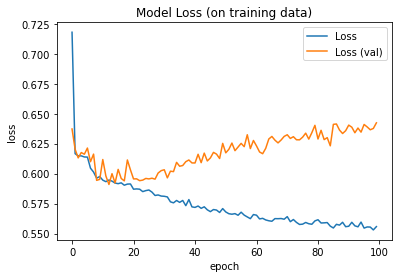

In [96]:
#Print model loss
plt.plot(history[0].history['loss'])
plt.plot(history[0].history['val_loss'])
plt.title('Model Loss (on training data)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Loss (val)'])
plt.show()

On voit que ce modèle a une tendance à overfit au delà 20 epochs

In [97]:
proba = model.predict(X_test)
print(proba[6])
print(y_prior_test[6])

[0.36800107 0.35510567 0.30455098 0.29189774 0.26724243 0.26100406
 0.28365678 0.3095967  0.32709497 0.35969657 0.2993199  0.22997321
 0.20929524 0.19069286 0.1896664  0.20592232 0.24621227 0.29451257
 0.34351158 0.2532811  0.1965081  0.18633376 0.16626778 0.16930573
 0.17521998 0.2078256  0.27629146 0.3329251  0.24093722 0.17534986
 0.18280019 0.15784393 0.16436446 0.15401274 0.1734026  0.24014129
 0.26817802 0.18155685 0.14650413 0.14918609 0.16532986 0.1452651
 0.15587288 0.16481951 0.24562107 0.22566748 0.14723215 0.14588834
 0.14842954 0.15185189 0.17539614 0.16288161 0.17958413 0.2408363
 0.1952192  0.13410355 0.12305612 0.14011924 0.15703203 0.18986674
 0.19403346 0.23102921 0.29912308 0.22852062 0.18033427 0.1544519
 0.18264927 0.21985592 0.22688878 0.25675538 0.30791265 0.34351537
 0.3282808  0.24230874 0.24724694 0.26747298 0.300767   0.34334522
 0.3550358  0.3506921  0.3718219  0.4026165 ]
[0.4  0.47 0.53 0.27 0.33 0.   0.   0.27 0.67 0.47 0.27 0.   0.33 0.
 0.   0.53 0.   0

In [54]:
model.save('model/model_priors.h5')

Second modèle qui lui va juste retourner la probabilité de gagner selon un plateau

In [57]:
model.pop()
model.add(Dense(1, activation='tanh'))
opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', optimizer=opt)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 9, 9, 64)          3520      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
batch_normalization_52 (Batc (None, 9, 9, 64)          256       
_________________________________________________________________
activation_52 (Activation)   (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
batch_normalization_53 (Batc (None, 9, 9, 64)        

In [58]:
# hyperparamètres
epochs = 50
batch_size = 64

history=[History()]

# training
print("Training ...")
model.fit(X_train, y_value_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_value_test),
          verbose=2,
          callbacks=history)

Training ...
Epoch 1/20
152/152 [==============================] - 6s 32ms/step - loss: 0.3193 - val_loss: 0.2232
Epoch 2/20
152/152 [==============================] - 5s 31ms/step - loss: 0.1604 - val_loss: 0.2272
Epoch 3/20
152/152 [==============================] - 5s 31ms/step - loss: 0.1607 - val_loss: 0.2218
Epoch 4/20
152/152 [==============================] - 5s 31ms/step - loss: 0.1617 - val_loss: 0.2301
Epoch 5/20
152/152 [==============================] - 5s 31ms/step - loss: 0.1604 - val_loss: 0.2218
Epoch 6/20
152/152 [==============================] - 5s 31ms/step - loss: 0.1604 - val_loss: 0.2346
Epoch 7/20
152/152 [==============================] - 5s 31ms/step - loss: 0.1610 - val_loss: 0.2274
Epoch 8/20
152/152 [==============================] - 5s 31ms/step - loss: 0.1594 - val_loss: 0.2236
Epoch 9/20
152/152 [==============================] - 5s 31ms/step - loss: 0.1597 - val_loss: 0.2230
Epoch 10/20
152/152 [==============================] - 5s 31ms/step - loss: 0.

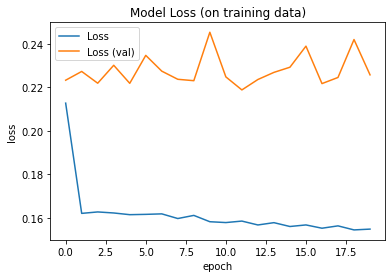

In [60]:
#Print model loss
plt.plot(history[0].history['loss'])
plt.plot(history[0].history['val_loss'])
plt.title('Model Loss (on training data)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Loss (val)'])
plt.show()

In [61]:
proba = model.predict(X_test)
print(proba[:6].reshape((-1, 6)))
print(y_value_test[:6])

[[-0.99999976 -0.99999976 -0.99999976 -0.04786064 -0.99999976 -0.99999976]]
[-0.02  -1.     0.144 -0.236 -1.    -1.   ]


In [62]:
model.save('model/model_values.h5')